## **Read me**

Le caselle non commentate sono quelle indispensabili per la pipeline. 

nella pipeline devi solo chiamare le funzioni cosi:

- validated_dp=validate_format(dp)
- checked_dp=check_range(validated_dp)
- imputed_dp=imputer(checked_dp)

poi ogni funzione si chiama le altre di conseguenza.

In [ ]:
import numpy as np
import pandas as pd

identity=['time', 'asset_id', 'name', 'kpi']
features=['sum', 'avg', 'min', 'max', 'var']

machine={'metal_cutting': ['ast-yhccl1zjue2t', 'ast-ha448od5d6bd', 'ast-6votor3o4i9l', 'ast-5aggxyk5hb36', 'ast-anxkweo01vv2', 'ast-6nv7viesiao7'],
'laser_cutting': ['ast-xpimckaf3dlf'],
'laser_welding': ['ast-hnsa8phk2nay', 'ast-206phi0b9v6p'],
'assembly': ['ast-pwpbba0ewprp', 'ast-upqd50xg79ir', 'ast-sfio4727eub0'],
'testing': ['ast-nrd4vl07sffd', 'ast-pu7dfrxjf2ms', 'ast-06kbod797nnp'],
'riveting': ['ast-o8xtn5xa8y87']}

# The following dictionary is organized as follows: for each type of kpi [key], the corrisponding value is a list of two elements - min and max of the expected range.
kpi={'energy_cost': [0, 1000], 
     'cost_per_unit': [0, 1000],
     'working_time': [0, 24], # Assuming that the information is reported in hours.
     'idle_time': [0, 24], # //
     'offline_time': [0, 24], # //
     'total_downtime_duration': [0, 24], #//
     'mtbf': [0, 24], #//
     'cycles_count': [0, 10000],
     'average_cycle_time': [0, 60], # Assumed to be expressed in minutes. 
     'good_cycle_count': [0, 10000],
     'bad_cycle_count': [0, 10000],
     'machine_working_consumption': [0, 100],
     'machine_idle_consumption': [0, 100],
     'carbon_foot_print': [0, 20]}

# Create the structure for storing batch and counter for each kpi that is produced in the company.
info = {}

for m in list(machine.keys()):
    info_asset = {}  # Reset for each machine
    for id in list(machine[m]):
        info_kpi = {}  # Reset for each asset
        for k in list(kpi.keys()):
            info_kpi[k] = [[[], [], [], [], []], [0, 0, 0, 0, 0]]  # One space for the batch and the other for the counter
        info_asset[id] = info_kpi  # Associate KPIs with the asset ID
    info[m] = info_asset  # Associate assets with the machine type
    

# At the end we have a nested dictionary where the atomic element can be retrieved as:
# info['machine_type']['asset_id']['kpi'] --> [batch, counter]
# The batch is a list of 5 sub-lists each containing the batch corrisponding to a specific features

In [23]:
#x['time', 'asset_id', 'name', 'kpi', 'sum', 'avg', 'min', 'max', 'var']

In [44]:
from collections import deque

class infoManager:
    def __init__(self, x):
        self.x=x
        self.machine=x['name']
        self.id=x['asset_id']
        self.kpi=x['kpi']
        self.b_length=40 # It can be changed

    def get_batch(self, f):        
        # This function will return batch, counter
        return list(info[self.machine][self.id][self.kpi][0][features.index(f)])
    
    def update_batch(self, f, p): 
        dq=deque(info[self.machine][self.id][self.kpi][0][features.index(f)])
        dq.append(p)
        
        if len(dq)>self.b_length:
            dq.popleft()
        # Store the new batch into the info dictionary.
        info[self.machine][self.id][self.kpi][0][features.index(f)]=dq
    
    def update_counter(self, f, reset=False):
        if reset==False:
            info[self.machine][self.id][self.kpi][1][features.index(f)]=info[self.machine][self.id][self.kpi][1][features.index(f)]+1
        else:
            info[self.machine][self.id][self.kpi][1][features.index(f)]=0
        return info[self.machine][self.id][self.kpi][1][features.index(f)] 

In [ ]:
# dp={}
# dp['time']=current_time.strftime('%Y-%m-%d %H:%M:%S')
# dp['asset_id']='ast-hnsa8phk2nay'
# dp['name']='laser_welding'
# dp['kpi']='idle_time'
# dp['min']=0
# dp['avg']=0
# dp['max']=0
# dp['sum']=0
# dp['var']=0

In [55]:
from collections import OrderedDict
from dateutil import parser
from datetime import timezone
from statsmodels.tsa.holtwinters import ExponentialSmoothing



def check_f_consistency(x):
    indicator=[True, True, True, True]
    if not np.isnan(x['min']) and not np.isnan(x['avg']):
        if x['min'] > x['avg']:
            indicator[2]=False
            indicator[1]=False
    if not np.isnan(x['min']) and not np.isnan(x['max']):
        if x['min'] > x['max']:
            indicator[2]=False
            indicator[3]=False
    if not np.isnan(x['min']) and not np.isnan(x['sum']):
        if x['min'] > x['sum']:
            indicator[2]=False
            indicator[0]=False
    if not np.isnan(x['avg']) and not np.isnan(x['max']):
        if x['avg'] > x['max']:
            indicator[1]=False
            indicator[3]=False
    if not np.isnan(x['avg']) and not np.isnan(x['sum']):
        if x['avg'] > x['sum']:
            indicator[1]=False
            indicator[0]=False
    if not np.isnan(x['max']) and not np.isnan(x['sum']):
        if x['max'] > x['sum']:
            indicator[0]=False
            indicator[3]=False
    return indicator

def validate_format(x):
    # Check if all essential columns are present: if the first four fields are missing then
    # the identity of the data point is unknown, thus, it needs to be deleted. 
    # Otherwise, (one of the remaining 4 fields in missing), set the missing column as missing. 
    # If all the aggregates are missing the data point is discarded as well.

    missing_identity = [field for field in identity if field not in list(x.keys())]
    missing_features = [field for field in features if field not in list(x.keys())]

    # Check is any identity field is missing or if any of them is nan.
    if missing_identity or any(pd.isna(x.get(key)) for key in identity):
        print('Data point misses essential fields. Discarded.')
        return None # In this case the data point is discarder: its identity is unknown.
    # Check if all the features that the datapoint has are nan or missing.
    elif all(pd.isna(x.get(key)) for key in features):
        print('Data point is useless becasue either all features are nan or missing. Discarded')
        return None # Also in this case the data point is discarded since it doesn't even contain the least meaningful information.
    else: # It means that the identity is well defined and at least one of the feature values is non nan --> the data point can be useful.
        for mf in missing_features:
            x[mf] = np.nan

    x = dict(OrderedDict((key, x[key]) for key in identity + features))

    # Try to set the format of the 'time' field into the most used one (ISO 8601 format in UTC)
    try:
        date_obj = parser.parse(x['time'])
        x['time'] = date_obj.replace(tzinfo=timezone.utc).isoformat(timespec='seconds').replace('+00:00', 'Z')
    except Exception as e:
        print("Invalid time format. Discarded data point.")
        return None
    
    # Check if the features (min, max, sum, avg) sarisfy the basic logic rule min<=avg<=max<=sum
    cc=check_f_consistency(x)
    if not any(cc): #meaning that no feature respect the logic rule
        return None #discard the datapoint: too much compromised.
    else:
        for f, c in zip(features, cc):
            if c==False:
                x[f]=np.nan
    return x

def check_range(x):
    flag=True
    if x: # Check the range only if the validation has not discarded the data point.
        l_thr=kpi[x['kpi']][0]
        h_thr=kpi[x['kpi']][1]
        for k in list(x.keys())[-5:] :
            if x[k]<l_thr:
                x[k]=np.nan
                flag=False
        if x['max']>h_thr:
            x['max']=np.nan
            flag=False
        return x, flag

def predict_missing(batch):
    seasonality=7
    cleaned_batch= [x for x in batch if not np.isnan(x)]
    #print(cleaned_batch)
    if not(all(pd.isna(x) for x in batch)) and batch:
        if len(cleaned_batch)>2*seasonality:
            print('**Use Exp Smoothing for prediction**')
            model = ExponentialSmoothing(cleaned_batch, seasonal='add', trend='add', seasonal_periods=seasonality)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=1)[0]
        else:
            print('**Use mean for prediction**')
            prediction=np.nanmean(batch)
        return prediction
    else: 
        return np.nan # Leave the feature as nan since we don't have any information in the batch to make the imputation.

def imputer(x):
    if x:
        x=x[0]
        nan_cons_thr=3
        im=infoManager(x)

        # Try imputation with mean or the HWES model.
        for f in features:
            batch = im.get_batch(f)
            if pd.isna(x[f]):
                    counter=im.update_counter(f)
                    x[f]=predict_missing(batch)
            else: 
                counter=im.update_counter(f, True)
            if counter>nan_cons_thr:
                point_id='/'.join(map(str, list(x.values())[1:4]+list([f])))
                print("It's been " + str(counter) + ' days that [' + str(point_id) + '] is missing')
        print(f'after imputation dp: {x}')

        # Check again the consistency of features and the range.
        if check_f_consistency(x) and check_range(x)[1]:
            pass
        else:  # It means that the imputed data point has not passed the check on the features and on their expected range.
            # In this case we use the LVCF as a method of imputation since it ensures the respect of these conditiono (the last point in the batch has been preiovusly checked)
            for f in features:
                batch=im.get_batch(f)
                x[f]=batch[-1]

        print(f'after check again dp: {x}')
        
        # In the end update batches with the new data point
        for f in features:
            print(f'original batch {f}: {im.get_batch(f)}')
            im.update_batch(f, x[f])
            print(f'batch after update {f}: {im.get_batch(f)}')

        return x


In [ ]:
# import pandas as pd
# import numpy as np

# # Load the .pkl file
# file_path = 'smart_app_data.pkl'
# df = pd.read_pickle(file_path)

# # Retrieve unique machines and KPIs from the DataFrame
# machines = df['name'].unique().tolist()
# kpis = df['kpi'].unique().tolist()

# def timseries_generator(machine_name, kpi):
#     # Filter data for the specific machine and KPI
#     filtered_df = df[(df['name'] == machine_name) & (df['kpi'] == kpi)].set_index('time')
#     return filtered_df.T

# t=timseries_generator(machines[8], kpis[0])
# t.loc['name']='metal_cutting'

In [ ]:
# original_stream=[]
# cleaned_stream=[]

# for time in t.columns:
#    print(f'---------------------- {time} --------------------')
#    sample=dict(t[time])
#    dp = {
#     'time': time,  
#     **{col: sample[col] for col in sample.keys() if col != 'time'} 
#     }
#    original_stream.append(dp.copy())
#    # Preprocessing part
#    print(f'original dp: {dp}')
#    validated_dp=validate_format(dp)
#    print(f'validated datapoint: {validated_dp}')
#    checked_dp=check_range(validated_dp)
#    print(f'checked datapoint: {checked_dp}')

#    final_dp=imputer(checked_dp)
#    if final_dp is None: #just for visualization purposes
#       final_dp={}
#       final_dp['time']=time
#       final_dp['asset_id']=dp['asset_id']
#       final_dp['name']=dp['name']
#       final_dp['kpi']=dp['kpi']
#       final_dp['min']=0
#       final_dp['avg']=0
#       final_dp['max']=0
#       final_dp['sum']=0
#       final_dp['var']=0
#    cleaned_stream.append(final_dp)
   

---------------------- 2024-03-01T00:00:00Z --------------------
original dp: {'time': '2024-03-01T00:00:00Z', 'asset_id': 'ast-6nv7viesiao7', 'name': 'metal_cutting', 'kpi': 'working_time', 'sum': 0.0, 'avg': 0.0, 'min': 0.0, 'max': 0.0}
validated datapoint: {'time': '2024-03-01T00:00:00Z', 'asset_id': 'ast-6nv7viesiao7', 'name': 'metal_cutting', 'kpi': 'working_time', 'sum': 0.0, 'avg': 0.0, 'min': 0.0, 'max': 0.0, 'var': nan}
checked datapoint: ({'time': '2024-03-01T00:00:00Z', 'asset_id': 'ast-6nv7viesiao7', 'name': 'metal_cutting', 'kpi': 'working_time', 'sum': 0.0, 'avg': 0.0, 'min': 0.0, 'max': 0.0, 'var': nan}, True)
It's been 234 days that [ast-6nv7viesiao7/metal_cutting/working_time/var] is missing
after imputation dp: {'time': '2024-03-01T00:00:00Z', 'asset_id': 'ast-6nv7viesiao7', 'name': 'metal_cutting', 'kpi': 'working_time', 'sum': 0.0, 'avg': 0.0, 'min': 0.0, 'max': 0.0, 'var': nan}
after check again dp: {'time': '2024-03-01T00:00:00Z', 'asset_id': 'ast-6nv7viesiao7', '

In [ ]:
# ################### THIS IS THE VERSION WITH THE GENERATIONOF RANDOM TIMESERIES

# from datetime import datetime, timedelta
# current_time = datetime(2024, 1, 1, 0, 0, 0)

# original_stream=[]
# nan_stream=[]
# cleaned_stream=[]

# for i in range(100):

#     print(f'----------------------------------- dp n. {i+1} --------------------------------')
#     # Generation part 
#     dp={}
#     dp['time']=current_time.strftime('%Y-%m-%d %H:%M:%S')
#     dp['asset_id']='ast-hnsa8phk2nay'
#     dp['name']='laser_welding'
#     dp['kpi']='idle_time'
#     dp['min']=np.random.uniform(-1, 5)
#     dp['avg']=np.random.uniform(3, 10)
#     dp['max']=np.random.uniform(8, 24)
#     dp['sum']=np.random.uniform(22, 30)
#     dp['var']=np.random.uniform(0, 30)
#     original_stream.append(dp.copy())
#     for f in features:
#         extracted=np.random.uniform(0, 10)
#         p=5
#         if (extracted < p/10): #40% prob of nan
#             dp[f]=np.nan
#     nan_stream.append(dp.copy())
#     current_time += timedelta(days=1)

#     # Preprocessing part
#     print(f'original dp: {dp}')
#     validated_dp=validate_format(dp)
#     print(f'validated datapoint: {validated_dp}')
#     checked_dp=check_range(validated_dp)
#     print(f'checked datapoint: {checked_dp}')

#     final_dp=imputer(checked_dp)
#     cleaned_stream.append(final_dp)


    


----------------------------------- dp n. 1 --------------------------------
original dp: {'time': '2024-01-01 00:00:00', 'asset_id': 'ast-hnsa8phk2nay', 'name': 'laser_welding', 'kpi': 'idle_time', 'min': 0.6390870250393521, 'avg': 8.822986366558913, 'max': 17.127790397132827, 'sum': 27.60435905309604, 'var': 23.90938653463963}
validated datapoint: {'time': '2024-01-01T00:00:00Z', 'asset_id': 'ast-hnsa8phk2nay', 'name': 'laser_welding', 'kpi': 'idle_time', 'sum': 27.60435905309604, 'avg': 8.822986366558913, 'min': 0.6390870250393521, 'max': 17.127790397132827, 'var': 23.90938653463963}
checked datapoint: ({'time': '2024-01-01T00:00:00Z', 'asset_id': 'ast-hnsa8phk2nay', 'name': 'laser_welding', 'kpi': 'idle_time', 'sum': 27.60435905309604, 'avg': 8.822986366558913, 'min': 0.6390870250393521, 'max': 17.127790397132827, 'var': 23.90938653463963}, True)
after imputation dp: {'time': '2024-01-01T00:00:00Z', 'asset_id': 'ast-hnsa8phk2nay', 'name': 'laser_welding', 'kpi': 'idle_time', 'sum':

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import datetime

# for ff in features:

#     # Extract time and min values
#     times = [datetime.strptime(entry['time'], '%Y-%m-%d %H:%M:%S') for entry in original_stream]
#     values_original = [entry[ff] for entry in original_stream]
#     values_nan = [entry[ff] for entry in nan_stream]
#     values_cleaned = [entry[ff] for entry in cleaned_stream]

#     # Identify NaN values
#     nan_mask = np.isnan(values_nan)
#     non_nan_times = [times[i] for i in range(len(times)) if not nan_mask[i]]
#     non_nan_min = [values_nan[i] for i in range(len(values_nan)) if not nan_mask[i]]
#     nan_times = [times[i] for i in range(len(times)) if nan_mask[i]]

#     values_original
#     mse = np.mean((np.array(values_cleaned) - np.array(values_original)) ** 2)
#     variance = np.var(values_original)

#     # NMSE
#     nmse = mse / variance
#     print("NMSE (variance-based):", nmse)
#     # Plot
#     plt.figure(figsize=(20, 6))
#     plt.title(ff)

#     # Plot non-NaN values
#     plt.plot(times, values_cleaned, label='cleaned', color='green', marker='o')

#     plt.plot(times, values_original, label='original', color='blue', marker='o')
#     plt.plot(times, values_nan, label='with nans', color='red', marker='o' )

#     # Highlight NaN days
#     if nan_times:
#         plt.scatter(nan_times, [0] * len(nan_times), color='red', label='NaN Days', zorder=5)

#     # Formatting
#     plt.xlabel('Date')
#     plt.ylabel('Min Value')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     #plt.xlim([datetime(2024, 10, 1, 0, 0), datetime(2024, 12, 1, 0, 0)])
#     plt.tight_layout()
#     plt.show()


NMSE (variance-based): 0.0


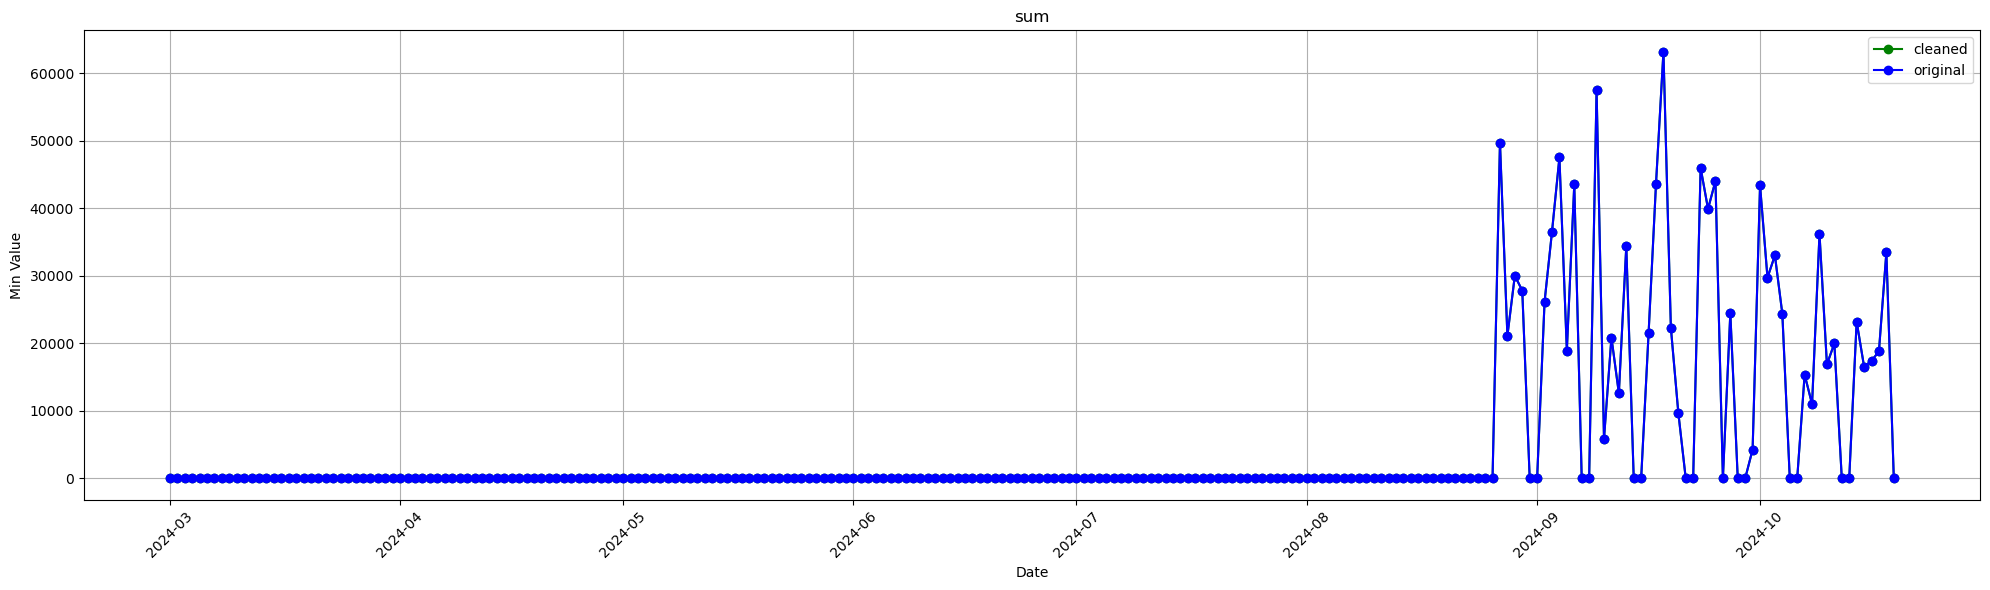

NMSE (variance-based): 0.0


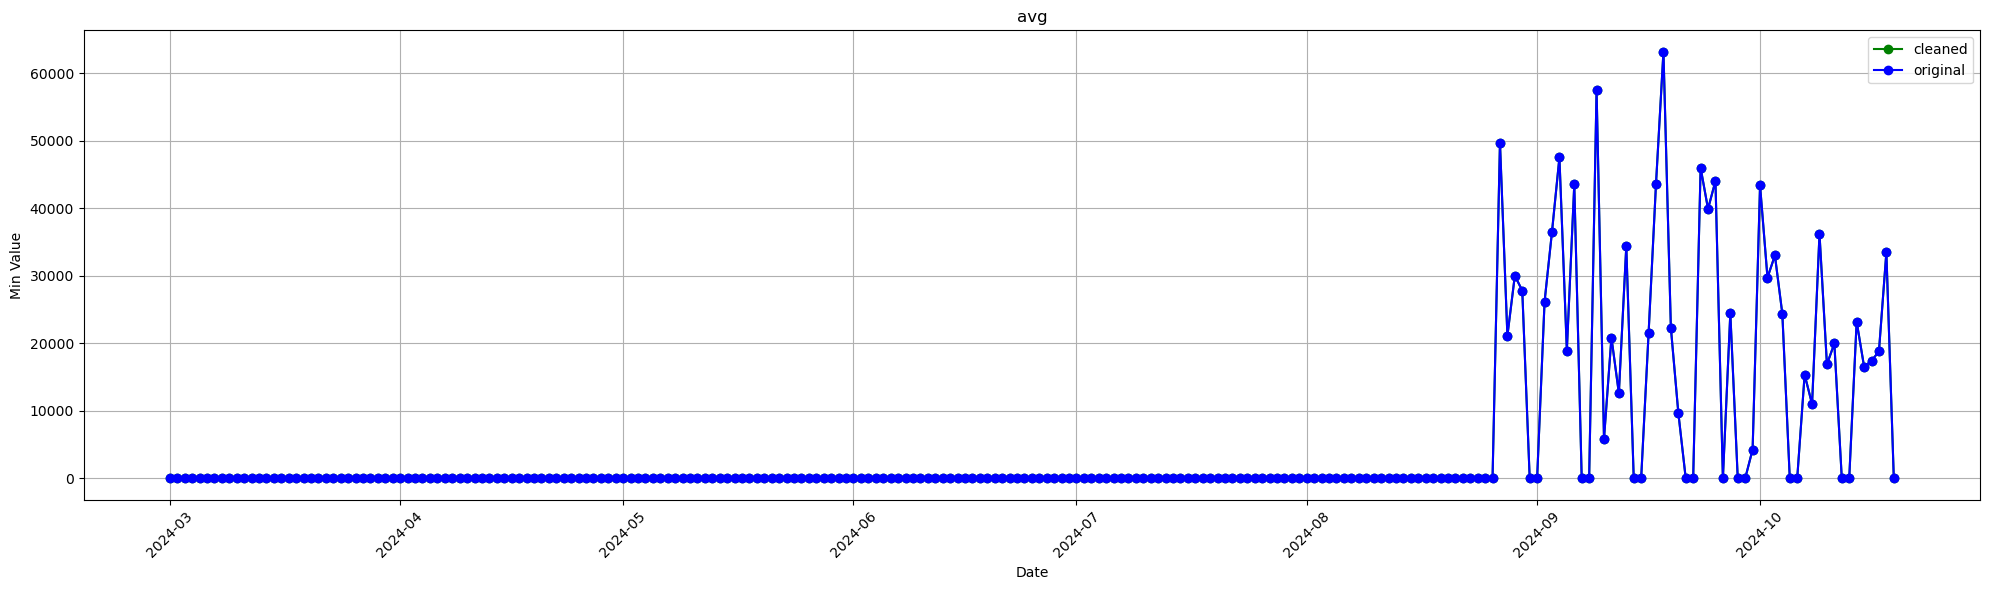

NMSE (variance-based): 0.0


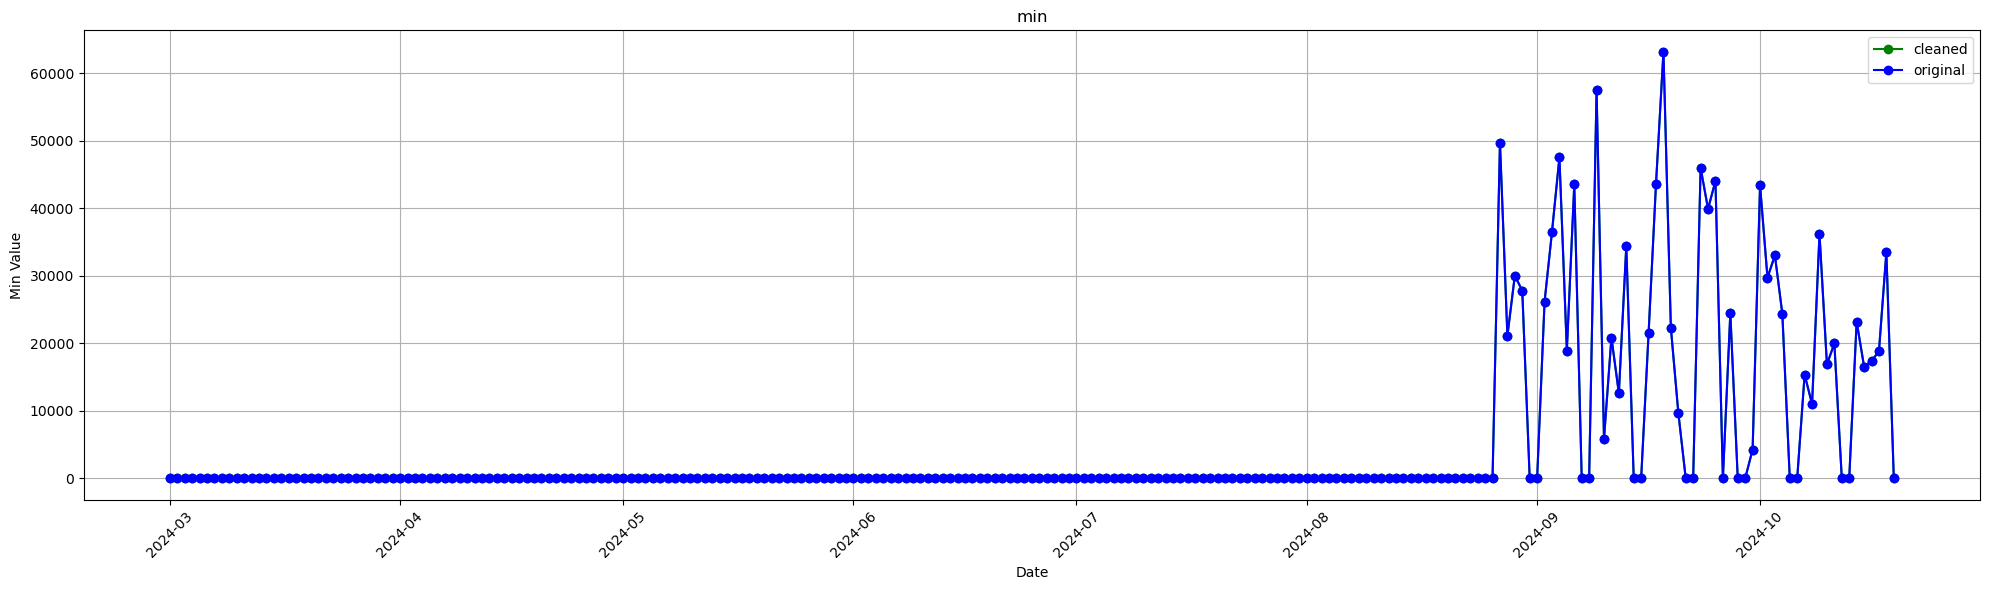

NMSE (variance-based): 0.0


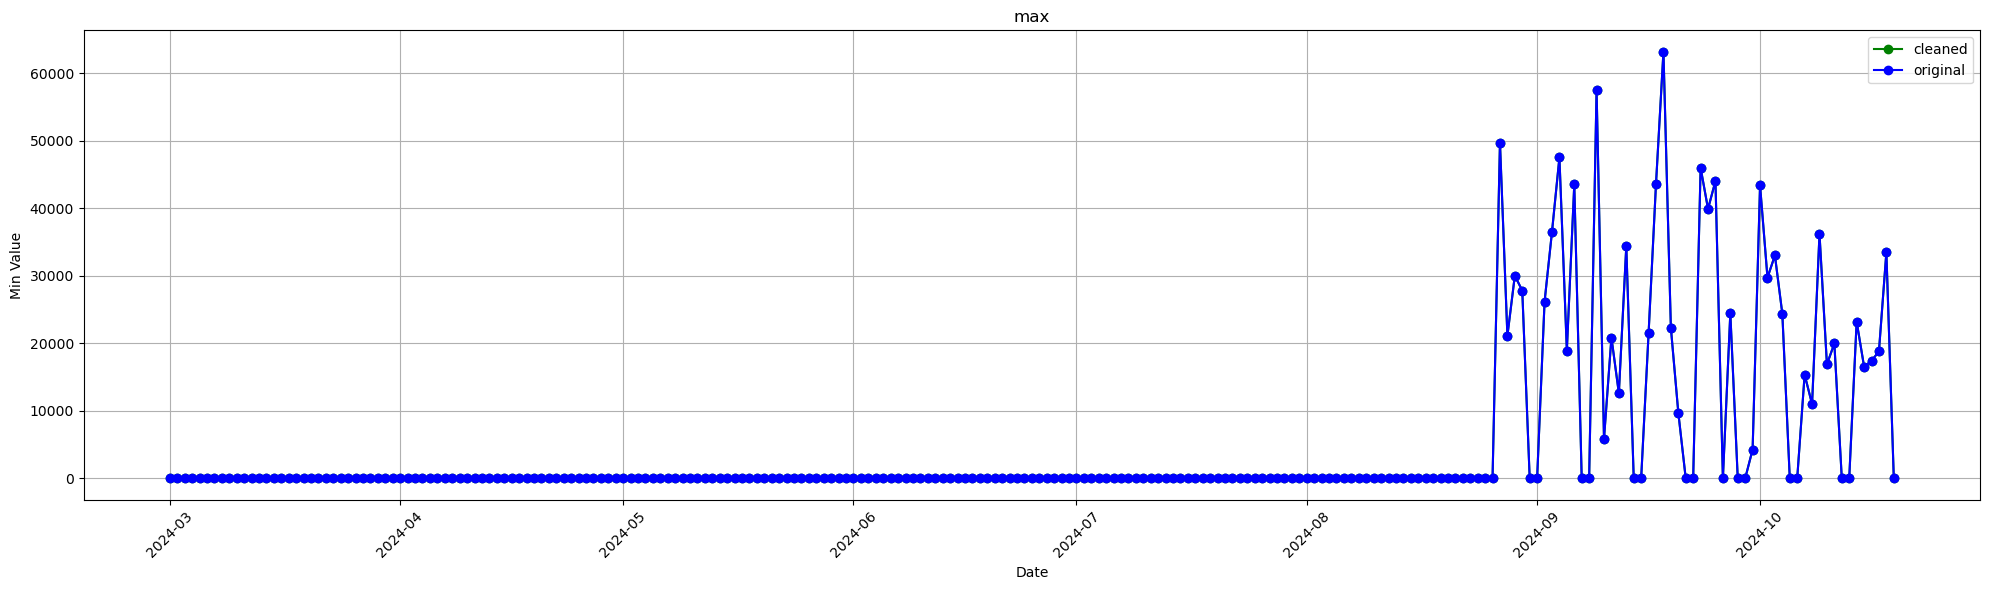

KeyError: 'var'

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from datetime import datetime

# for ff in features:

#     # Extract time and min values
#     times = [datetime.strptime(entry['time'], '%Y-%m-%dT%H:%M:%SZ') for entry in original_stream]
#     values_original = [entry[ff] for entry in original_stream]
#     values_cleaned = [entry[ff] for entry in cleaned_stream]

#     # Identify NaN values
#     nan_mask = np.isnan(values_original)
#     non_nan_times = [times[i] for i in range(len(times)) if not nan_mask[i]]
#     non_nan_min = [values_original[i] for i in range(len(values_original)) if not nan_mask[i]]
#     nan_times = [times[i] for i in range(len(times)) if nan_mask[i]]

#     values_original
#     mse = np.mean((np.array(values_cleaned) - np.array(values_original)) ** 2)
#     variance = np.var(values_original)

#     # NMSE
#     nmse = mse / variance
#     print("NMSE (variance-based):", nmse)
#     # Plot
#     plt.figure(figsize=(20, 6))
#     plt.title(ff)

#     # Plot non-NaN values
#     plt.plot(times, values_cleaned, label='cleaned', color='green', marker='o')

#     plt.plot(times, values_original, label='original', color='blue', marker='o')

#     # Highlight NaN days
#     if nan_times:
#         plt.scatter(nan_times, [0] * len(nan_times), color='red', label='NaN Days', zorder=5)

#     # Formatting
#     plt.xlabel('Date')
#     plt.ylabel('Min Value')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     #plt.xlim([datetime(2024, 10, 1, 0, 0), datetime(2024, 12, 1, 0, 0)])
#     plt.tight_layout()
#     plt.show()
